# Sentiment analysis

Sentiment analysis modelling is a classification task, which is used in NLP applications to identify and extract the insights.

Sentiment Analysis Model transform the opinions found in data into actionable insights, by takes in a huge corpus of data and finds a pattern and comes up with a conclusion based on real evidence rather than assumptions made on a small sample of data.

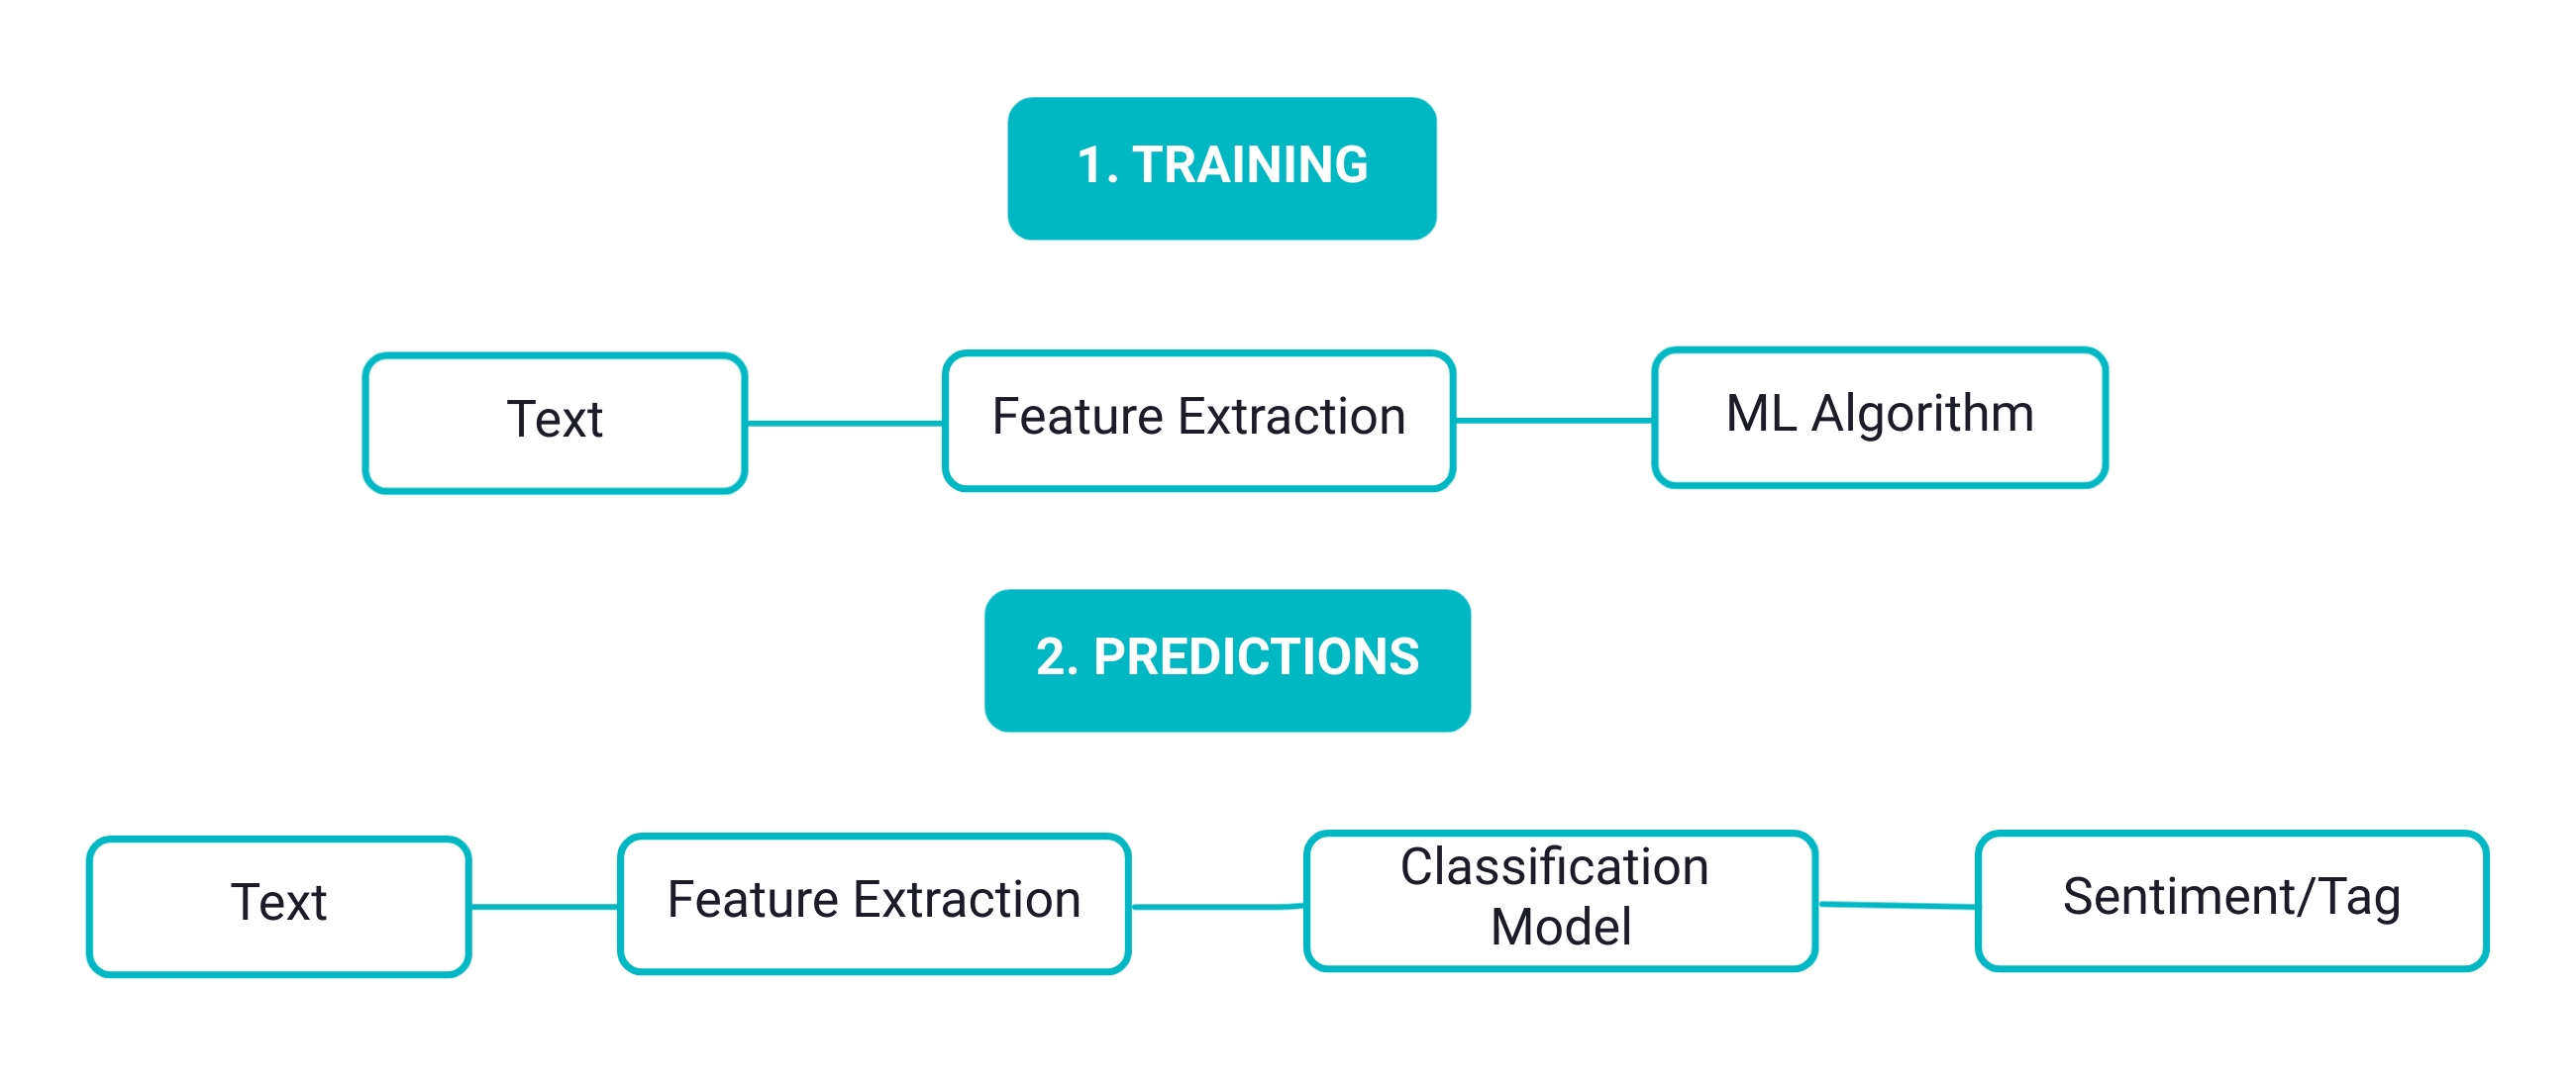



In [ ]:
import tensorflow as tf                                        # tensorflow for modelling
import numpy as np                                             # numpy for math computations
import matplotlib.pyplot as plt                                # visualizations
import sklearn                                                 # scikit-learn
import cv2                                                     # image processing
from sklearn.metrics import confusion_matrix, roc_curve        # metrics
import seaborn as sns                                          # visualizations
import datetime
import pathlib
import io
import os
import re
import string
import time
from numpy import random
import gensim.downloader as api
from PIL import Image
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Dense,Flatten,SimpleRNN,InputLayer,Conv1D,Bidirectional,GRU,LSTM,BatchNormalization,Dropout,Input, Embedding,TextVectorization)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from google.colab import files
from tensorboard.plugins import projector

In [ ]:
BATCH_SIZE=64

# Data Preparation

In [ ]:
# Download dataset and split into train, validation and test set.

train_ds,val_ds,test_ds=tfds.load('imdb_reviews', split=['train', 'test[:50%]', 'test[50%:]'],as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete6G58CL/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete6G58CL/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete6G58CL/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# investigate few sample of validation set.
# Here in dataset, label 0= negative review & 1=positve review.

for review,label in val_ds.take(5):
  print(review)
  print(label)

tf.Tensor(b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come.", shape=(), dtype=string)
tf.Tensor(1, shape=(),

# Text standardization

Text standardization is a pre-processing step aimed at improving the quality of the text and making it suitable for machines to process.

standardization techniques we will be implementing-

*   Trasnform given input into the lowercase equivalent.
*   Convert to lower case : Because we will be creating a vocabulary of our corpus, where we don't want model to treat a word which is in the beginning of a sentence with a capital letter different from the same word which appears later in the sentence without any capital latter.
*   Take off html tags, using regex expressions.

*   Remove punctuation with empty string.
*   Trasnform words to it's base form - remove special characters, accidented characters
*   Stemming: The process of removing affixes from a word so that we are left with the stem of that word is called stemming. For example, consider the words 'run', 'running', and 'runs', all convert into the root word 'run' after stemming is implemented on them.


*   Lemmatization: It is quite similar to the Stemming process, the difference is it does more in-dept analysis of the input word and it break a word down to its root meaning to identify similarities.

In [ ]:
def standardization(input_data):
    '''
    Input: raw reviews
    output: standardized reviews
    '''
    lowercase=tf.strings.lower(input_data)                                             # text will be lowercased.
    no_tag=tf.strings.regex_replace(lowercase,"<[^>]+>","")                            # regex expression for removing html tags.
    output=tf.strings.regex_replace(no_tag,"[%s]"%re.escape(string.punctuation),"")    # all punctuation removed.

    return output

In [ ]:
standardization(tf.constant("<u>In the movie?, </u>man called Raj, went to a friend's pl**ce and they had a tensed discussion. I don't love this movie! would you?<br> <br /><br />T"))

<tf.Tensor: shape=(), dtype=string, numpy=b'in the movie man called raj went to a friends plce and they had a tensed discussion i dont love this movie would you t'>

# Text tokenization:

Tokenization is the process of breaking text into words of sentences. These tokens helps machine to learn context of the text. This helps in interpreting the meaning behind the text.

Given a character sequence and a defined document unit, tokenization is the task of chopping it up into pieces, called tokens , perhaps at the same time throwing away certain characters, such as punctuation.

A tokenizer breaks unstructured data and natural language text into chunks of information that can be considered as discrete elements. The token occurrences in a document can be used directly as a vector representing that document.

This immediately turns an unstructured string (text document) into a numerical data structure suitable for machine learning.

**Tokenization strategies in NLP:**
*   Character tokenization: Input sentence broken up into servel character tokens. So here, each & every character is considered to be a single token. And next step would be to vectorized/numeric these tokens, by creating vocabulary to map unique ID to each tokens.

*   Word tokenization: Here, instead of considering each character to be a token, we consider each word to be a single token. OOV (Out Of Vocabulary) is the major problem with word tokenizer. When the unseen word comes in testing this method failes.

*   sub-word tokenization: In sub word tokenization we split words into subwords so the word “enjoyed” will become [“enjoy”,”ed”], which will be added in vocabulary list. And ## is used to indicates that ##ed is a subword and is preceded by another word.So the vocabulary will become [“n”,”enjoy”,”##ed”,”n”]

*    N-grams: vocabulary will be formed by a combination of successive N-words.It split the sentence into multiple sequences of tokens depending upon the value of n.
N-grams are continuous sequences of words or symbols, or tokens in a document. It can be defined as the neighboring sequences of items in a document.

N-grams are the most powerful technique to extract the features from the text.
It has a wide range of applications in language models, spelling correctors, text classification problems, and more.





# vectorization of tokens

*   One-hot: One hot encoding is a vector representation of words in a “vocabulary”. Each word in the vocabulary is represented by a vector of size N, where N is the total number of words in the vocabulary. For instance, if a vocabulary contains 10 words, then the vector corresponding to each word will have a size of 10, and that too with binary values like 0 and 1.

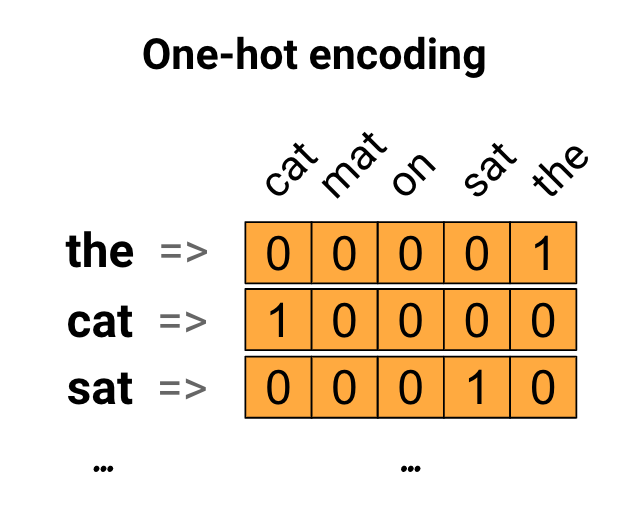


*   Bag-of-words (BoW): The intuition is that documents are similar if they have similar content.

BoW is a representation of text that describes the occurrence/frequency of words within a document.

It is called a “bag” of words, because any information about the order or structure of words in the document is discarded. The model is only concerned with whether known words occur in the document, not where in the document.

An example of BoW:

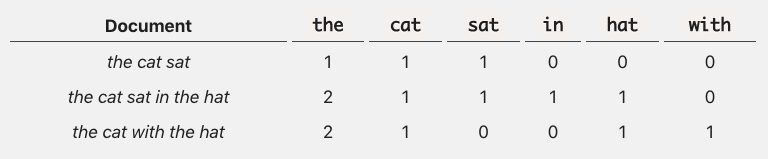


*   Term Frequency-Inverse Document Frequency (Tf-IDF): TF-IDF is an information retrieval method that relies on Term Frequency (TF) and Inverse Document Frequency (IDF) to measure the importance of a word in a document.

What makes TF-IDF so effective:

In a document, not all words have equal significance, and therefore, one can assign weights to these words based on their term frequency and inverse document frequency. Words like ‘the’, ‘and’, ‘he’ etc., appear very frequently, but they don’t carry any weightage.

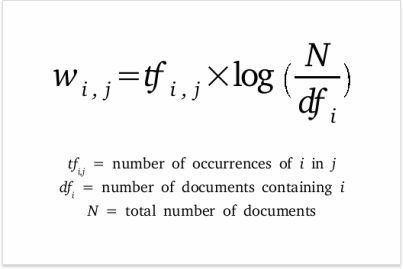

The TF-IDF weightage of a word in the document is calculated as the product of term frequency and inverse document frequency of that word. This product is higher for rare terms in the document and relatively lower for commonly used words.

Term Frequency:
Term Frequency is the number of times a specific word appeared in the document divided by the total number of words in the document.

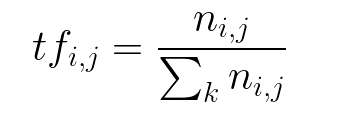

Inverse Document Frequency:

The inverse document frequency measures whether a term is common or rare in a given document. It is obtained by dividing the total number of documents by the number of documents containing the term in the corpus.

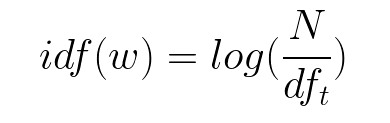

Once these two metrics have been calculated, they can be combined to get a new measure: the term frequency × the inverse document frequency.

This product reflects how important a word is with respect to a given document in a corpus of documents.


In [ ]:
# config VOCAB_SIZE, SEQUENCE_LENGTH & EMBEDDING_DIM

VOCAB_SIZE=10000
SEQUENCE_LENGTH=250
EMBEDDING_DIM=300

In [ ]:
# If we don't to set/guess what should be the VOCAB_SIZE & SEQUENCE_LENGTH, we could try a more deeper look at the dataset.
# Here, we are getting all the unique words in train dataset 100 sentences.
lengths=[]
words=[]

for review,label in train_ds.take(100):
  for word in tf.strings.split(review, sep=" "):
    if word in words:
      pass
    else:
      words.append(word)
  lengths.append(len(tf.strings.split(review, sep=" ")))

In [ ]:
print(lengths)

[116, 112, 132, 88, 81, 289, 557, 111, 223, 127, 164, 277, 545, 141, 332, 84, 312, 420, 267, 333, 186, 306, 255, 118, 196, 128, 169, 160, 163, 148, 229, 484, 207, 111, 81, 218, 121, 188, 106, 127, 128, 450, 454, 94, 145, 103, 170, 481, 192, 280, 70, 231, 39, 233, 136, 136, 289, 714, 209, 155, 161, 257, 235, 151, 277, 122, 264, 98, 177, 413, 251, 71, 115, 50, 170, 121, 367, 126, 163, 168, 133, 92, 745, 140, 184, 255, 64, 263, 188, 136, 161, 545, 77, 55, 863, 117, 68, 159, 138, 125]


In [ ]:
print(np.mean(lengths))

213.86


In [ ]:
print(len(words))

6507


In [ ]:
print(words)

[<tf.Tensor: shape=(), dtype=string, numpy=b'This'>, <tf.Tensor: shape=(), dtype=string, numpy=b'was'>, <tf.Tensor: shape=(), dtype=string, numpy=b'an'>, <tf.Tensor: shape=(), dtype=string, numpy=b'absolutely'>, <tf.Tensor: shape=(), dtype=string, numpy=b'terrible'>, <tf.Tensor: shape=(), dtype=string, numpy=b'movie.'>, <tf.Tensor: shape=(), dtype=string, numpy=b"Don't">, <tf.Tensor: shape=(), dtype=string, numpy=b'be'>, <tf.Tensor: shape=(), dtype=string, numpy=b'lured'>, <tf.Tensor: shape=(), dtype=string, numpy=b'in'>, <tf.Tensor: shape=(), dtype=string, numpy=b'by'>, <tf.Tensor: shape=(), dtype=string, numpy=b'Christopher'>, <tf.Tensor: shape=(), dtype=string, numpy=b'Walken'>, <tf.Tensor: shape=(), dtype=string, numpy=b'or'>, <tf.Tensor: shape=(), dtype=string, numpy=b'Michael'>, <tf.Tensor: shape=(), dtype=string, numpy=b'Ironside.'>, <tf.Tensor: shape=(), dtype=string, numpy=b'Both'>, <tf.Tensor: shape=(), dtype=string, numpy=b'are'>, <tf.Tensor: shape=(), dtype=string, numpy=b'

In [ ]:
# Tensorflow text Vectorization
# Here, arguments -
# max_tokens describes the maximum size of the vocabulary for this layer.
# standardize, whose role is literally to standardize the inputs text, where we could pass customize function, which should do standardization process. So we will be using our own function.
# output_sequence_length, signifies the maximum length of our different sentences.

vectorize_layer=TextVectorization(
    standardize=standardization,
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH
)

In [ ]:
# construct training data
training_data=train_ds.map(lambda x,y:x)  # input x and y and outputx

# create our vocabulary using tensorflow adapt method on our training_data set.
vectorize_layer.adapt(training_data)      # adapt the vectorize_layer to the training data

In [ ]:
# vocabulary list
vectorize_layer.get_vocabulary()

['',
 '[UNK]',
 'the',
 'and',
 'a',
 'of',
 'to',
 'is',
 'in',
 'it',
 'this',
 'i',
 'that',
 'was',
 'as',
 'with',
 'for',
 'movie',
 'but',
 'film',
 'on',
 'not',
 'are',
 'you',
 'his',
 'have',
 'be',
 'he',
 'one',
 'its',
 'at',
 'all',
 'by',
 'an',
 'they',
 'who',
 'from',
 'like',
 'so',
 'her',
 'or',
 'just',
 'about',
 'has',
 'out',
 'if',
 'some',
 'what',
 'there',
 'good',
 'more',
 'very',
 'when',
 'she',
 'even',
 'up',
 'no',
 'would',
 'my',
 'which',
 'only',
 'time',
 'really',
 'story',
 'their',
 'were',
 'had',
 'see',
 'can',
 'me',
 'than',
 'we',
 'much',
 'been',
 'get',
 'well',
 'will',
 'into',
 'because',
 'people',
 'other',
 'also',
 'do',
 'bad',
 'great',
 'how',
 'first',
 'most',
 'him',
 'dont',
 'made',
 'movies',
 'then',
 'films',
 'make',
 'could',
 'way',
 'them',
 'any',
 'too',
 'after',
 'characters',
 'think',
 'watch',
 'two',
 'many',
 'being',
 'seen',
 'character',
 'never',
 'little',
 'acting',
 'plot',
 'where',
 'best',
 '

In [ ]:
len(vectorize_layer.get_vocabulary())

10000

In [ ]:
# now we would like to check vectorized version of review & label, by passing it inot our vectorize_layer,
# which has been adapted on our full dataset, we will be able to convert this into numbers.

def vectorizer(review,label):
    return vectorize_layer(review),label

In [ ]:
# mapp dataset onto all, which is now vectorized.
train_dataset=train_ds.map(vectorizer)
val_dataset=val_ds.map(vectorizer)

In [ ]:
# check vectorized train_dataset
for review,label in train_dataset.take(1):
  print(review)
  print(label)

tf.Tensor(
[[  10   13   33 ...    0    0    0]
 [  11   25   73 ...    0    0    0]
 [4799 6235    2 ...    0    0    0]
 ...
 [   4  638    3 ... 3067   67   10]
 [4204   36   10 ...    0    0    0]
 [  11  151  514 ...    0    0    0]], shape=(64, 250), dtype=int64)
tf.Tensor(
[0 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 0 0 0 0 1 1
 0 0 1 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1], shape=(64,), dtype=int64)


In [ ]:
# check vectorized train_dataset
for review,label in val_dataset.take(1):
  print(review)
  print(label)

tf.Tensor(
[[  48   22   93 ...    0    0    0]
 [   4    1  717 ...    1 3465 1676]
 [ 623   17 2616 ... 5995 4224  157]
 ...
 [ 313  309  296 ...    0    0    0]
 [  89   74 4459 ...    0    0    0]
 [ 720   42 1945 ...  231    6    1]], shape=(64, 250), dtype=int64)
tf.Tensor(
[1 1 0 0 1 1 1 1 0 1 0 0 1 0 1 0 1 0 1 0 0 1 0 0 1 1 0 0 0 1 1 1 1 1 0 1 1
 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 1 1 0 1 1 1 0 0 0 1 0 0], shape=(64,), dtype=int64)


In [ ]:
vectorize_layer.get_vocabulary()[1]

'[UNK]'

In [ ]:
# check our initial sentences
for review,label in train_ds.take(1):
  print(review)
  print(label)

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


In [ ]:
for review,label in train_dataset.take(1):
  print(review)
  print(label)

tf.Tensor(
[  10   13   33  411  384   17   89   26    1    8   32 1337 3521   40
  491    1  192   22   84  149   18   10  215  317   26   64  239  212
    8  484   54   64   84  111   95   21 5502   10   91  637  737   10
   17    7   33  393 9554  169 2443  406    2   87 1205  135   65  142
   52    2    1 7408   65  245   64 2832   16    1 2851    1    1 1415
 4969    3   39    1 1567   15 3521   13  156   18    4 1205  881 7874
    8    4   17   12   13 4037    5   98  145 1234   11  236  696   12
   48   22   91   37   10 7285  149   37 1337    1   49  396   11   95
 1148  841  140    9    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

Now we could see that, all sentences has been vectorized, and length 250. Here "This" has been vectorized into 10  and 411 is "absolutely" and so on.

And unkown word "lured" which is represented by 1, which is being too unpopular or was not occured more in our dataset, so it did't makeup into the first 10,000 words in the vocabulary. And so that's why we have this unknown token.

In [ ]:
# Prefetching for more efficient loading of data.

train_dataset=train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset=val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

# Build model

# Simple_RNN model

In [ ]:
# Here inputs takes on batch_size, sequence_length & vocabulary size
inputs=np.random.random([32, 10, 8]).astype(np.float32)

simple_rnn=tf.keras.layers.SimpleRNN(25)
# number of units=25, simply gives us the dimension of the each vectors, which will be outputting.
# And the information we pass in from one block top another will be 25-D
# Increasing this parameter results in, having more weights & reducing vice versa.
# So if we want our model to be larger, we increse number of units parameter.

output=simple_rnn(inputs)
print(output.shape)

(32, 25)


In [ ]:
EMBEDDING_DIM=64

# Build our model with tensorflow sequential model.
# In sequential models, we stack up multiple same/or different layers where one's output goes into another ahead.
# This is the default structure with neural nets. Dense is a layer type (fully connected layer).

model=tf.keras.models.Sequential([

    Input(shape=(SEQUENCE_LENGTH,)),       # shape would be 250, for each & every input.
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),   # then we pass in to Embedding layer, which takes care of mapping each token in sequnence onto 64 EMBEDDING_dim dimension vector.
    SimpleRNN(32),                         # pass into SimpleRNN model & we collect the last output, as we have not specified return sequences to true,so by default it is False.
    Dense(1,activation='sigmoid'),         # Dense layer with 1 output neuron, activation function is sigmoid as, we want our outputs to be between (0,1)
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 64)           640000    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 643,137
Trainable params: 643,137
Non-trainable params: 0
_________________________________________________________________


# Keras Callbacks API

A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc).

You can use callbacks to:


*   Write TensorBoard logs after every batch of training to monitor your metrics
*   Do early stopping
*  Periodically save your model to disk
*   ...and more

**ModelCheckpoint class:**
Callback to save the Keras model or model weights at some frequency.

ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.

A few options this callback provides include:


*   Definition of 'best'; which quantity to monitor and whether it should be maximized or minimized.
*   The frequency it should save at, such as saving at the end of every epoch, or after a fixed number of training batches.

Arguments:


*   filepath: string or PathLike, path to save the model file.
*   monitor: The metric name to monitor and the metrics are set by the Model.compile method.

*   mode: one of {'auto', 'min', 'max'}. If save_best_only=True, the decision to overwrite the current save file is made based on either the maximization or the minimization of the monitored quantity. For val_acc, this should be max, for val_loss this should be min, etc

*   Save_best_only: if save_best_only=True, it only saves when the model is considered the "best" and the latest best model according to the quantity monitored will not be overwritten.

**Why do we need ModelCheckpoint callback?**

If our model is big and training takes hours or days? most of the times, due to out of memory (OOM) or lack of GPU access issues causes the training process to stop and, restarting the training from scratch is costly and time consuming.

Practically, Machine Learning models will get new data continuously. We can add the new data to the training data and use the latest checkpoint to retrain the model so that performance is better.


In [ ]:
# create checkpoint:
# here, each time we obatin validation accuracy higher than the current highest validation accuracy,
# we are going to save the model weights.

checkpoint_filepath = '/content/drive/MyDrive/nlp/sentiment_analysis/rnn.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
# Configures the model for training:

# In ML, Loss function is used to find error or deviation in the learning process,
# we will be using Binary Cross entropy loss function, because our output can be either negative review 0 or positive review 1.

# Optimization is an important process which optimize the input weights by comparing the prediction and the loss function, we will be using Adam optimizer.
# Metrics is used to evaluate the performance of your model. It is similar to loss function, but not used in training process, for this we will use accuracy metric.

model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
# Train the model

# here, we are training the model with the given inputs=train_dataset and corresponding training labels= val_dataset.
# epochs − no of times the model is needed to be evaluated during training.

history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[model_checkpoint_callback])

Epoch 1/10
391/391 [==============================] - 175s 438ms/step - loss: 0.6954 - accuracy: 0.4962 - val_loss: 0.6940 - val_accuracy: 0.5019
Epoch 2/10
391/391 [==============================] - 130s 332ms/step - loss: 0.6842 - accuracy: 0.5562 - val_loss: 0.6960 - val_accuracy: 0.4998
Epoch 3/10
391/391 [==============================] - 142s 363ms/step - loss: 0.6575 - accuracy: 0.6294 - val_loss: 0.7034 - val_accuracy: 0.5102
Epoch 4/10
391/391 [==============================] - 155s 395ms/step - loss: 0.5962 - accuracy: 0.7227 - val_loss: 0.7160 - val_accuracy: 0.5190
Epoch 5/10
391/391 [==============================] - 134s 343ms/step - loss: 0.5106 - accuracy: 0.8044 - val_loss: 0.7352 - val_accuracy: 0.5336
Epoch 6/10
391/391 [==============================] - 122s 312ms/step - loss: 0.4271 - accuracy: 0.8594 - val_loss: 0.7605 - val_accuracy: 0.5398
Epoch 7/10
391/391 [==============================] - 124s 317ms/step - loss: 0.3570 - accuracy: 0.8969 - val_loss: 0.7858 -

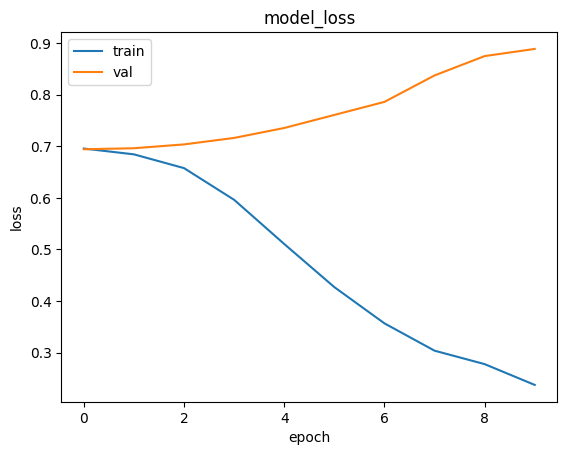

In [ ]:
# plot model loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

The above plot suggests, loss for training data drops while that of the validation data increases slowly, which is not what we expect or ideal.

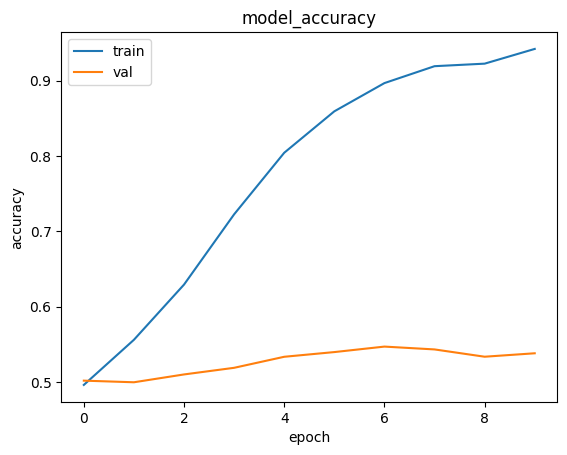

In [ ]:
# plot model accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Here, accuracy is seems to be constant for the validation data & for the training data accuracy goes above 90%. So it seems our model isn't going perfoming well on unseen data, so there is requirement to take several measures to impove the model perfomance, so that model would do better generalization to predict pattern of unseen data.

# Model Evaluation


In [ ]:
model.load_weights(checkpoint_filepath)

In [ ]:
test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
model.evaluate(train_dataset)

391/391 [==============================] - 14s 36ms/step - loss: 0.3116 - accuracy: 0.8809


[0.3116317689418793, 0.8808799982070923]

**To understand why model performed so poorly, let's first look at how Neural network models are trained by the optimization algorithm of gradient descent:**
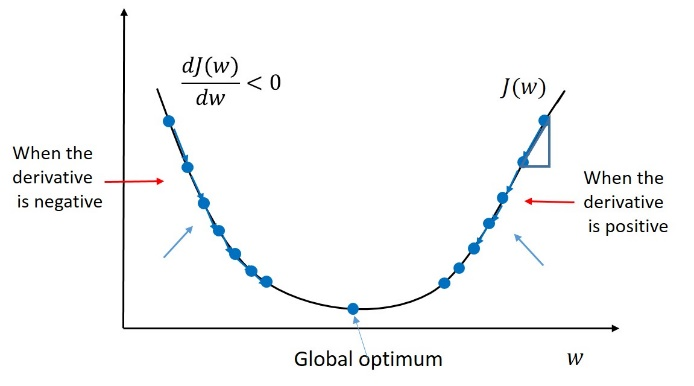

The input training data helps these models learn, and the loss function gauges how accurate the prediction performance is for each iteration when parameters get updated. As training goes, the goal is to reduce the loss function/prediction error by adjusting the parameters iteratively. Specifically, the gradient descent algorithm has a forward step and a backward step, which lets it do this.

*   In forward propagation, input vectors/data move forward through the network using a formula to compute each neuron in the next layer. The formula consists of input/output, activation function f, weight W and bias b:


This computation iterates forward until it reaches an output or prediction. We then calculate the difference defined by a loss function, e.g., Mean Squared Error MSE, between the target variable y (in the output layer) and each prediction, y cap:

*  With this initial evaluation, we go through a backward pass (a.k.a. backpropagation) to adjust the weights and biases for each neuron in each layer. To update our neural nets, we first calculate the gradients, which is nothing but the derivatives of the loss function w.r.t. weights and biases. Then we nudge our algorithm to take a gradient descent step to minimize the loss function (where alpha is the learning rate):


Two opposite scenarios could happen in this case: the derivative term gets extremely small, i.e., approaches zero vs. this term gets extremely large and overflows. These issues are referred to as the Vanishing and Exploding Gradients, respectively.

When you train your model for a while and the performance doesn’t seem to get better, chances are your model is suffering from either vanishing or exploding gradients.



# Why model performed poorly:

There should be two main reasons why this model perfomed so poorly.

1.   Vanishing gradients & exploding gradients

*   Vanishing: During backpropagation, the calculation of (partial) derivatives/gradients in the weight update formula follows the Chain Rule, where gradients in earlier layers are the multiplication of gradients of later layers.

  As the gradients frequently become SMALLER until they are close to zero, the new model weights (of the initial layers) will be virtually identical to the old weights without any updates.
  As a result, the gradient descent algorithm never converges to the optimal solution, this is known as the problem of vanishing gradients.

*   Exploding: On the contrary, if the gradients get LARGER or even NaN as our backpropagation progresses, we would end up with exploding gradients having big weight updates, leading to the divergence of the gradient descent algorithm.

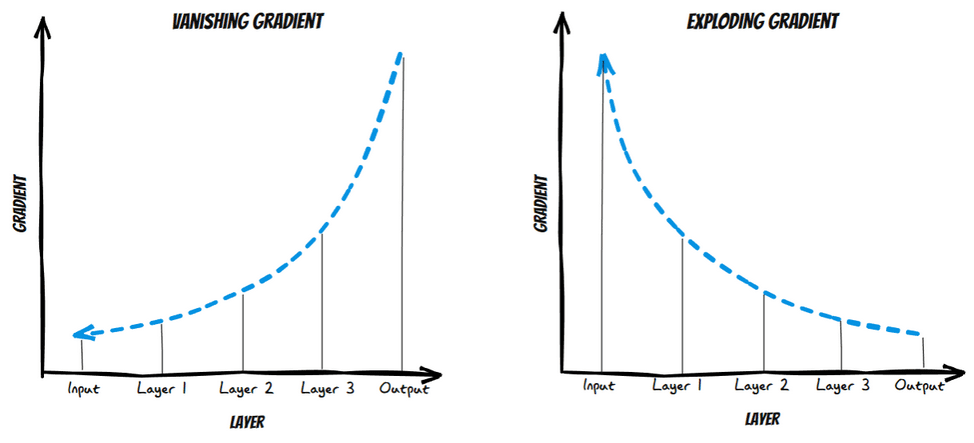






2.  Due to problem of short-term memory

It should be noted that these problems arises due to the fact that we're dealing with very long sequnce, specifically sequnce length of 250, as we had defined in the model. This simply means that, information at the very beginning doesn't get to the end. As information moves from one cell to another, at some point it showhow gets lost due to long distance this information has to travel.



# what are the methods to seek out better model performance:

*   Normalization: With this method we center our features around a given mean value, by subtracting this mean from the features & rescale this values w.r.t. standard deviation.

* Batch Normalization:

  It consists of adding an operation in the model just before or after the activation function of each hidden layer.

  This operation simply zero-centers and normalizes each input, then scales and shifts the result using two new parameter vectors per layer: one for scaling, the other for shifting.

  In other words, the operation lets the model learn the optimal scale and mean of each of the layer’s inputs.

  To zero-center and normalize the inputs, the algorithm needs to estimate each input’s mean and standard deviation.
  It does so by evaluating the mean and standard deviation of the input over the current mini-batch (hence the name “Batch Normalization”).

*   Using Non-saturating Activation Functions:

  As aforementioned, the vanishing gradients problem is due to the saturating nature of the Sigmoid or Tanh function. Hence, an effective remedy would be to switch to other activation functions that are non-saturated for their derivative, e.g., ReLU (Rectified Linear Unit)

*   Gradient Clipping:

  Gradient Clipping is a method where the error derivative is changed or clipped to a threshold during backward propagation through the network, and using the clipped gradients to update the weights.

  In this method, once we compute gradient & find that graident value is above a certain threshold value, then we are going to clip it. SO this means that if we set the threshold to be 0.1 & we obtain any graident above 0.1, then we're going to bring this value back to 0.1.

  By rescaling the error derivative, the updates to the weights will also be rescaled, dramatically decreasing the likelihood of an overflow or underflow.

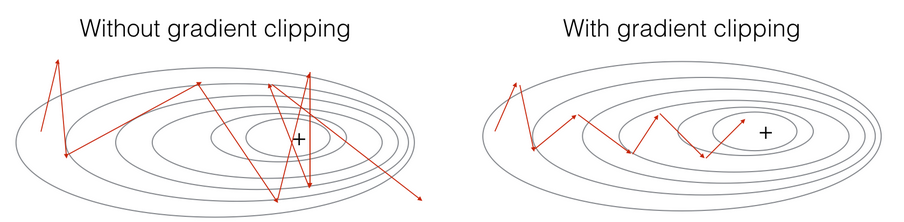




